In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
temp_train = pd.read_csv("./temp_train.csv")
temp_test = pd.read_csv("./temp_test.csv")

In [4]:
predictNames = ['LassoPred', 'XGBPred', 'KNNPred', 'RFPred']
checkNames = ['MSSubClass','Functional','MSZoning', 'Neighborhood', 'SaleType', 'SaleCondition', 'SalePrice']
new_data = pd.DataFrame()
for name in predictNames:
    tempFrame = train.loc[:,checkNames]
    tempFrame.loc[:,'type'] = name
    tempFrame.loc[:,'Pred'] = temp_train.loc[:,name]
    new_data = pd.concat((new_data, tempFrame))
new_data.loc[:,'SalePrice'] = np.log1p(new_data.loc[:,'SalePrice'])

In [5]:
new_data.tail()

,MSSubClass,Functional,BldgType,MSZoning,Neighborhood,SaleType,SaleCondition,SalePrice,type,Pred
1455,60,Typ,1Fam,RL,Gilbert,WD,Normal,12.072547,RFPred,12.074455
1456,20,Min1,1Fam,RL,NWAmes,WD,Normal,12.254868,RFPred,12.216073
1457,70,Typ,1Fam,RL,Crawfor,WD,Normal,12.493133,RFPred,12.444464
1458,20,Typ,1Fam,RL,NAmes,WD,Normal,11.864469,RFPred,11.858907
1459,20,Typ,1Fam,RL,Edwards,WD,Normal,11.901590,RFPred,11.922829


In [5]:
new_data.loc[:,'Residule'] = new_data['SalePrice'] - new_data['Pred']

In [1]:
matplotlib.rcParams['figure.figsize'] = (14.0, 6.0)
sns.boxplot(data = new_data, y = 'Residule', x = 'MSSubClass', hue = 'type')

NameError: name 'matplotlib' is not defined

In [67]:
# new_train = train[['MSZoning', 'Neighborhood', 'SaleType', 'SaleCondition']]
new_train[predictNames] = temp_train[predictNames]
Y = np.log1p(train['SalePrice'])

In [68]:
new_train = pd.get_dummies(new_train)

In [69]:
new_train.tail()

,RidgePred,XGBPred,KNNPred,RFPred,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blmngtn,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1455,12.078200,12.077914,12.086670,12.087902,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,12.252821,12.222839,12.202478,12.242167,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1457,12.546716,12.439274,12.387044,12.455193,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1458,11.902509,11.830789,11.790908,11.820641,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1459,11.873724,11.869223,11.928491,11.923318,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

ensemble_score = cross_val_score(
    estimator = LinearRegression(),
    X = new_train, 
    y = Y,
    n_jobs = 4,
    cv = 5,
    scoring = 'neg_mean_squared_error'
)
print np.sqrt(- ensemble_score.mean())

0.12067246988


In [71]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

tree_params = {
    'max_depth' : range(5,17,2),
    'min_samples_split' : range(10,101,10)
}

tree_search = GridSearchCV(
    estimator = DecisionTreeRegressor(),
    param_grid = tree_params,
    n_jobs = 4,
    cv = 5,
    scoring = 'neg_mean_squared_error'
)
tree_search.fit(X = new_train, y = Y)
zip(np.sqrt(-tree_search.cv_results_['mean_test_score']),tree_search.cv_results_['params']), tree_search.best_params_,np.sqrt(- tree_search.best_score_)

([(0.13070265684348534, {'max_depth': 5, 'min_samples_split': 10}),
  (0.12071324006331585, {'max_depth': 5, 'min_samples_split': 20}),
  (0.12562822655898942, {'max_depth': 5, 'min_samples_split': 30}),
  (0.12969016361648891, {'max_depth': 5, 'min_samples_split': 40}),
  (0.12593173103381505, {'max_depth': 5, 'min_samples_split': 50}),
  (0.12546990978152006, {'max_depth': 5, 'min_samples_split': 60}),
  (0.12528247053851962, {'max_depth': 5, 'min_samples_split': 70}),
  (0.1255044336694853, {'max_depth': 5, 'min_samples_split': 80}),
  (0.12584672476653413, {'max_depth': 5, 'min_samples_split': 90}),
  (0.12624390539455546, {'max_depth': 5, 'min_samples_split': 100}),
  (0.14113033765177041, {'max_depth': 7, 'min_samples_split': 10}),
  (0.13449638349207363, {'max_depth': 7, 'min_samples_split': 20}),
  (0.13418407095345869, {'max_depth': 7, 'min_samples_split': 30}),
  (0.13735398308470734, {'max_depth': 7, 'min_samples_split': 40}),
  (0.13159871950485974, {'max_depth': 7, 'min_sa

In [72]:
from sklearn.linear_model import Lasso
lasso_param_test = {
#     'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,3]
    'alpha': np.arange(0.0005,0.005,0.0002)
}

lasso_search = GridSearchCV(
    estimator = Lasso(),
    param_grid = lasso_param_test, 
    scoring='neg_mean_squared_error',
    n_jobs=1,
    iid=False, 
    cv=5
)
lasso_search.fit(new_train,Y)
zip(np.sqrt(-lasso_search.cv_results_['mean_test_score']),lasso_search.cv_results_['params']), lasso_search.best_params_,np.sqrt(- lasso_search.best_score_)

([(0.11632936742460573, {'alpha': 0.00050000000000000001}),
  (0.11577342213962323, {'alpha': 0.00069999999999999999}),
  (0.11536862739563306, {'alpha': 0.00089999999999999998}),
  (0.11517224060743156, {'alpha': 0.0010999999999999998}),
  (0.11508043665482928, {'alpha': 0.0012999999999999999}),
  (0.11502062981172727, {'alpha': 0.0015}),
  (0.11497282715048403, {'alpha': 0.0016999999999999999}),
  (0.114932241010617, {'alpha': 0.0018999999999999998}),
  (0.1149052434465298, {'alpha': 0.0020999999999999999}),
  (0.11488248891406969, {'alpha': 0.0023}),
  (0.11487543000978938, {'alpha': 0.0025000000000000001}),
  (0.11490558579537276, {'alpha': 0.0026999999999999997}),
  (0.114944517100107, {'alpha': 0.0028999999999999998}),
  (0.11498645035674929, {'alpha': 0.0030999999999999999}),
  (0.11503152442128223, {'alpha': 0.0032999999999999995}),
  (0.11508012347995163, {'alpha': 0.0034999999999999996}),
  (0.11513175933294736, {'alpha': 0.0036999999999999997}),
  (0.11518625367882565, {'alp

In [73]:
new_test = test[['MSZoning', 'Neighborhood', 'SaleType', 'SaleCondition']]
new_test[predictNames] = temp_test[predictNames]
new_test = pd.get_dummies(new_test)

In [74]:
predVal = lasso_model.predict(new_test)
result = pd.DataFrame({'Id' : test['Id'], "SalePrice" : np.expm1(predVal)})

In [75]:
result.to_csv('result.csv', index = False)

In [76]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
X_train_train, X_train_test, Y_train, Y_test = train_test_split(new_train, Y, test_size = 0.3, random_state = 42)

def plot_train_cv(start, end, step):
    train_train_rmse, train_test_rmse = [], []
    for i in (start + step * x for x in range(int((end - start) / step) + 1)):
        merged_pred = i * X_train_train['XGBPred'] + (1.0 - i) * X_train_train['RidgePred']
        train_train_rmse.append(np.sqrt(mean_squared_error(Y_train, merged_pred)))
        merged_pred = i * X_train_test['XGBPred'] + (1.0 - i) * X_train_test['RidgePred']
        train_test_rmse.append(np.sqrt(mean_squared_error(Y_test, merged_pred)))
    ensemble_rmse = pd.DataFrame(index = [start + step * x for x in range(int((end - start) / step) + 1)], data = {"TrainRMSE" : train_train_rmse, "TestRMSE" : train_test_rmse})
    ensemble_rmse.plot()
    print (ensemble_rmse['TestRMSE'].argmin(), ensemble_rmse['TestRMSE'].min())

(0.26000000000000001, 0.10762432991920363)


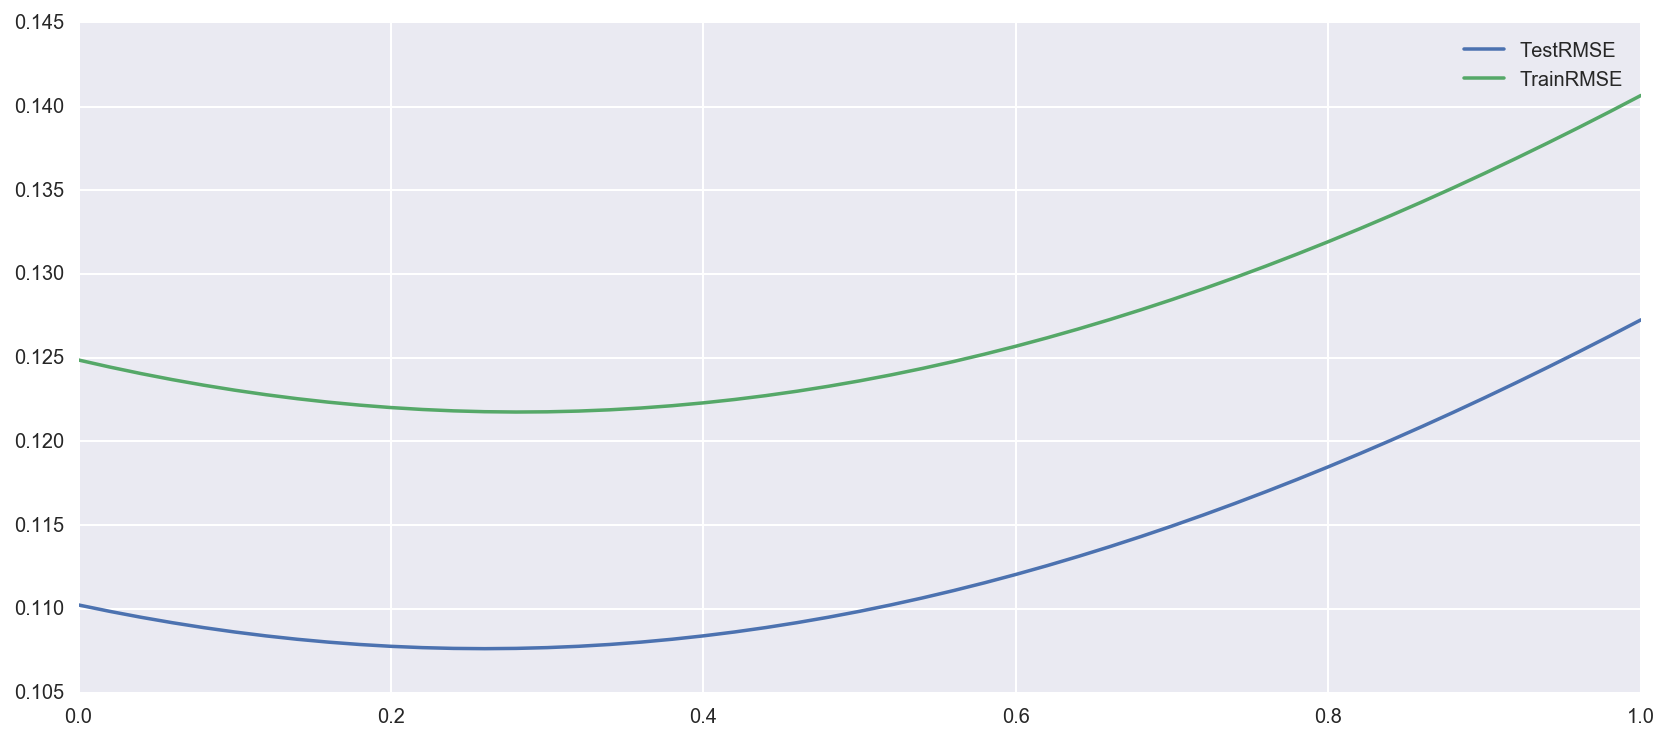

In [77]:
plot_train_cv(0, 1, 0.02)

In [78]:
predVal = 0.26 * temp_test['XGBPred'] + 0.74 * temp_test['RidgePred']
result = pd.DataFrame({'Id' : test['Id'], "SalePrice" : np.expm1(predVal)})

In [79]:
result.to_csv('result.csv', index = False)